# A planet from TESS with TLS
Here we use TLS to recover WASP-139 in TESS data. The URL for the FITS file is from the [MAST](https://archive.stsci.edu/prepds/tess-data-alerts/).

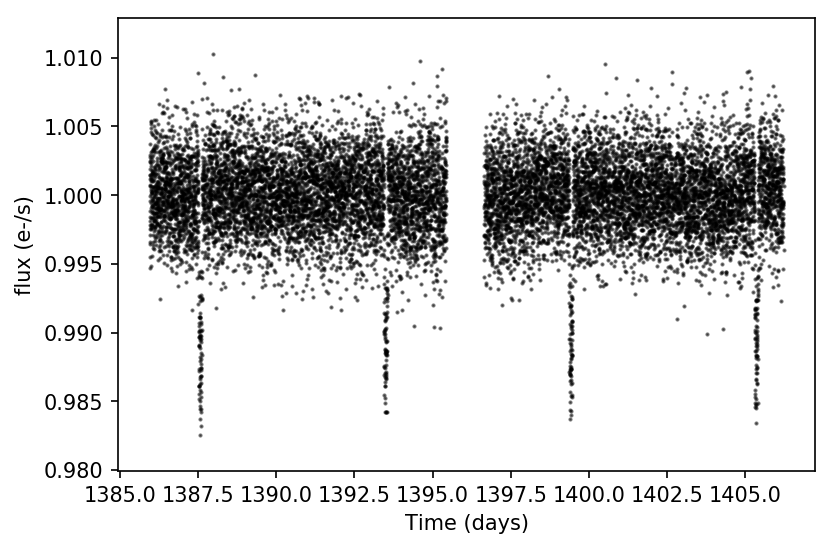

In [25]:
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 150
import astropy
import numpy
from astropy.io import fits
from astropy.stats import sigma_clip

from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

# We find the URLs of the FITS files on this website:
# https://archive.stsci.edu/prepds/tess-data-alerts/
url = 'https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00159951311-s03_tess_v1_lc.fits'
hdu = fits.open(url)
time = hdu[1].data['TIME']
flux = hdu[1].data['PDCSAP_FLUX']  # values with non-zero quality are nan or zero'ed
time, flux = cleaned_array(time, flux)  # remove invalid values such as nan, inf, non, negative
flux = flux / numpy.median(flux)

plt.figure()
plt.xlabel('Time (days)')
plt.ylabel('flux (e-/s)')
plt.scatter(time, flux, color='black', s=1, alpha=0.5);

In this particular light curve, there is no need for detrending. Also, the transits are visible by-eye. Perfect for a maximally simple tutorial! We can add limb-darkening information from the TESS catalog to improve the TLS search. We use the TIC_ID which we pull from the FITS file header:

In [8]:
TIC_ID = hdu[0].header['TICID']
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(TIC_ID=TIC_ID)
print('Searching with limb-darkening estimates using quadratic LD (a,b)=', ab)

Searching with limb-darkening estimates using quadratic LD (a,b)= (0.4036, 0.2028)


We could also use the mass and radius estimate to refine TLS's period grid, but skip this step for simplicity. We now run the search:

In [9]:
model = transitleastsquares(time, flux)
results = model.power(u=ab)

  0%|          | 0/1744 periods | 00:00<?

Transit Least Squares TLS 1.0.22 (15 February 2019)
Creating model cache for 26 durations
Searching 13452 data points, 1744 periods from 0.601 to 10.133 days
Using all 8 CPU threads


100%|██████████| 1744/1744 periods | 00:05<00:00


OK, so this took only a few seconds even without mass and radius constraints. Let's see the periodiogram:

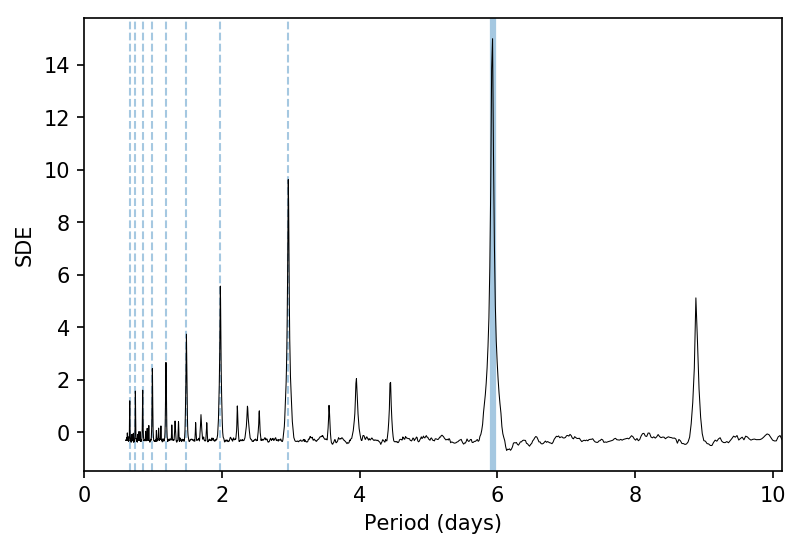

In [10]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

That's a strong signal. Let's look at the phase fold:

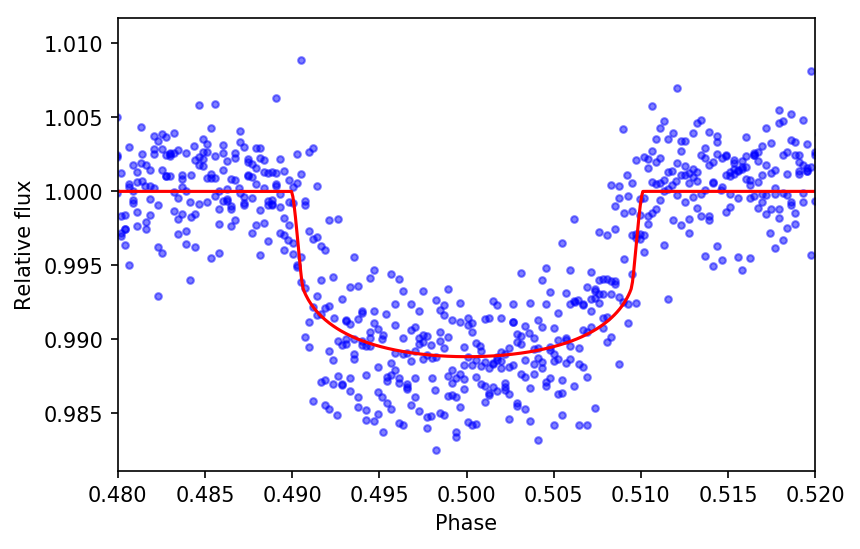

In [11]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

Looks like an acceptable, although not perfect fit. 
Let's look at the complete light curve with in-transit points (red points), model (red line), and out-of-transit points (blue):

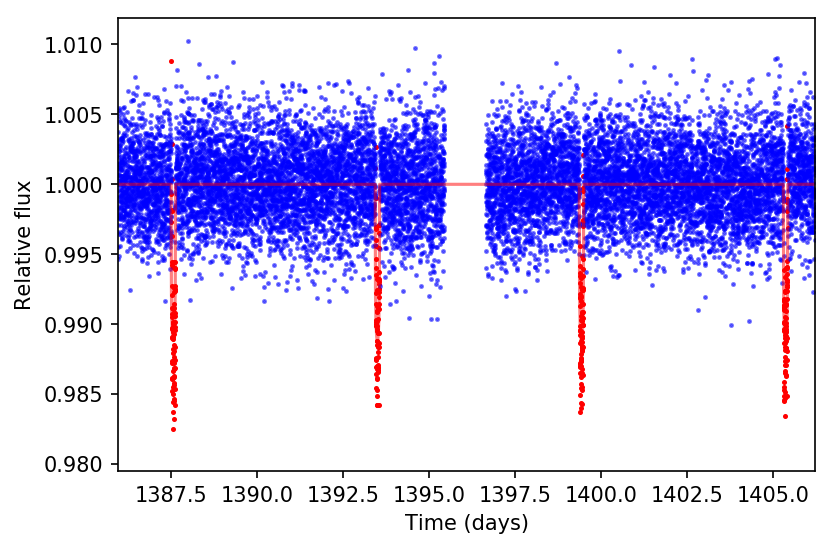

In [13]:
plt.figure()
in_transit = transit_mask(time, results.period, results.duration, results.T0)
plt.scatter(time[in_transit], flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(time[~in_transit], flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(time.min(), time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

There are 4 clear transits. But are the individual transit depths consistent with each other?

Period 5.92926 d at T0= 1387.564717534036
4 transit times in time series: ['1387.56472', '1393.49398', '1399.42324', '1405.35251']
Number of data points during each unique transit [83. 83. 83. 83.]
The number of transits with intransit data points 4
The number of transits with no intransit data points 0
Transit depth 0.98882 (at the transit bottom)
Transit duration (days) 0.11530
Transit depths (mean) [0.99006821 0.99046671 0.99033088 0.99052142]
Transit depth uncertainties [0.00049573 0.00042286 0.00043635 0.00045164]


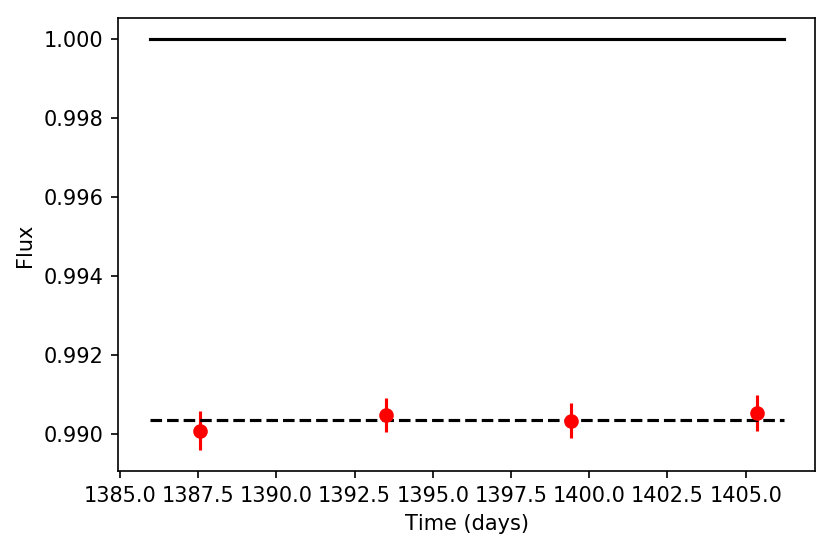

In [28]:
print('Period', format(results.period, '.5f'), 'd at T0=', results.T0)
print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Number of data points during each unique transit', results.per_transit_count)
print('The number of transits with intransit data points', results.distinct_transit_count)
print('The number of transits with no intransit data points', results.empty_transit_count)
print('Transit depth', format(results.depth, '.5f'), '(at the transit bottom)')
print('Transit duration (days)', format(results.duration, '.5f'))
print('Transit depths (mean)', results.transit_depths)
print('Transit depth uncertainties', results.transit_depths_uncertainties)

plt.figure()
plt.errorbar(
    results.transit_times,
    results.transit_depths,
    yerr=results.transit_depths_uncertainties,
    fmt='o', color='red')
plt.plot(
    (time.min(), time.max()),
    (numpy.mean(results.transit_depths), numpy.mean(results.transit_depths)),
     color='black', linestyle='dashed')
plt.plot((time.min(), time.max()), (1, 1), color='black')
plt.xlabel('Time (days)')
plt.ylabel('Flux');

Yes, that looks good. All depths are within $\sim1\,\sigma$ of each other.